In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

df_siec = pd.read_csv("df_siec.csv")

agregados = ["EU27_2020", "EU28", "EA19", "EA20", "EA", "EFTA", "EU15", "EU25", "EU27"]
df_siec = df_siec[~df_siec["geo"].isin(agregados)].copy()

exclude_cols = ["geo", "TIME_PERIOD", "PIB_growth_pct"]
siec_cols = [c for c in df_siec.columns if c not in exclude_cols]

df_siec_log = df_siec.copy()
df_siec_log[siec_cols] = df_siec_log[siec_cols].clip(lower=0)
df_siec_log[siec_cols] = np.log1p(df_siec_log[siec_cols])

In [3]:
print(df_siec_log.columns.tolist())

['geo', 'TIME_PERIOD', 'AFC_Bioenergía', 'AFC_Carbón', 'AFC_Eólica', 'AFC_Gas', 'AFC_Hidráulica', 'AFC_Nuclear', 'AFC_Petróleo', 'AFC_Renovables_total', 'AFC_Solar', 'DL_Bioenergía', 'DL_Carbón', 'DL_Eólica', 'DL_Gas', 'DL_Hidráulica', 'DL_Nuclear', 'DL_Petróleo', 'DL_Renovables_total', 'DL_Solar', 'FC_E_Bioenergía', 'FC_E_Carbón', 'FC_E_Eólica', 'FC_E_Gas', 'FC_E_Hidráulica', 'FC_E_Nuclear', 'FC_E_Petróleo', 'FC_E_Renovables_total', 'FC_E_Solar', 'FC_IND_E_Bioenergía', 'FC_IND_E_Carbón', 'FC_IND_E_Eólica', 'FC_IND_E_Gas', 'FC_IND_E_Hidráulica', 'FC_IND_E_Nuclear', 'FC_IND_E_Petróleo', 'FC_IND_E_Renovables_total', 'FC_IND_E_Solar', 'FC_OTH_E_Bioenergía', 'FC_OTH_E_Carbón', 'FC_OTH_E_Eólica', 'FC_OTH_E_Gas', 'FC_OTH_E_Hidráulica', 'FC_OTH_E_Nuclear', 'FC_OTH_E_Petróleo', 'FC_OTH_E_Renovables_total', 'FC_OTH_E_Solar', 'FC_TRA_E_Bioenergía', 'FC_TRA_E_Carbón', 'FC_TRA_E_Eólica', 'FC_TRA_E_Gas', 'FC_TRA_E_Hidráulica', 'FC_TRA_E_Nuclear', 'FC_TRA_E_Petróleo', 'FC_TRA_E_Renovables_total', 'F

In [ ]:
import pandas as pd
import numpy as np

energy_cols = ['AFC_Bioenergía', 'AFC_Carbón', 'AFC_Eólica', 'AFC_Gas', 'AFC_Hidráulica', 
               'AFC_Nuclear', 'AFC_Petróleo', 'AFC_Renovables_total', 'AFC_Solar']
export_cols = ['GEP_Bioenergía', 'GEP_Carbón', 'GEP_Eólica', 'GEP_Gas', 'GEP_Hidráulica',
               'GEP_Nuclear', 'GEP_Petróleo', 'GEP_Renovables_total', 'GEP_Solar']
pib_col = 'PIB_real_MEUR'

df_filtered = df_siec_log[['geo', 'TIME_PERIOD'] + energy_cols + export_cols + [pib_col]].copy()

df_filtered = df_filtered.dropna(subset=[pib_col])

df_filtered = df_filtered.set_index(['geo', 'TIME_PERIOD'])

In [ ]:
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

y = df_filtered[pib_col]
X = df_filtered[energy_cols + export_cols]

X = sm.add_constant(X)

model = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,
    time_effects=True
).fit(cov_type="clustered", cluster_entity=True)

print(model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:          PIB_real_MEUR   R-squared:                        0.3426
Estimator:                   PanelOLS   R-squared (Between):              0.2754
No. Observations:                1025   R-squared (Within):               0.1374
Date:                Mon, Nov 10 2025   R-squared (Overall):              0.2945
Time:                        10:29:53   Log-likelihood                    1057.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      27.133
Entities:                          37   P-value                           0.0000
Avg Obs:                       27.703   Distribution:                  F(18,937)
Min Obs:                      10.0000                                           
Max Obs:                       34.000   F-statistic (robust):             27.133
                            

In [ ]:
for col in energy_cols + export_cols:
    df_filtered[f"{col}_lag5"] = df_filtered.groupby("geo")[col].shift(5)

df_filtered['PIB_real_MEUR_lag5'] = df_filtered.groupby("geo")['PIB_real_MEUR'].shift(-5)

df_lagged = df_filtered.dropna(
    subset=[f"{col}_lag5" for col in energy_cols + export_cols] + ['PIB_real_MEUR_lag5']
)

In [ ]:
from linearmodels.panel import PanelOLS
import pandas as pd
import numpy as np
import statsmodels.api as sm

all_cols = energy_cols + export_cols

df_model = df_siec_filtered.reset_index(drop=False).copy()

for col in all_cols:
    df_model[f"{col}_lag5"] = df_model.groupby("geo", group_keys=False)[col].shift(5)

df_model["PIB_real_MEUR_lag5"] = df_model.groupby("geo", group_keys=False)["PIB_real_MEUR"].shift(-5)

lagged_cols = [f"{col}_lag5" for col in all_cols]
df_model = df_model.dropna(subset=lagged_cols + ["PIB_real_MEUR_lag5"])

df_model = df_model.set_index(["geo", "TIME_PERIOD"])

y = df_model["PIB_real_MEUR_lag5"]
X = df_model[all_cols + lagged_cols]

y, X = y.align(X, join="inner")

y = pd.to_numeric(y, errors="coerce")
X = X.apply(pd.to_numeric, errors="coerce")

X = X.dropna(axis=1, how="all")
y, X = y.align(X, join="inner")

model_lag = PanelOLS(
    y, X,
    entity_effects=True,
    time_effects=True
).fit(cov_type="clustered", cluster_entity=True)

print(model_lag.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:     PIB_real_MEUR_lag5   R-squared:                        0.5013
Estimator:                   PanelOLS   R-squared (Between):              0.1697
No. Observations:                 655   R-squared (Within):               0.2550
Date:                Mon, Nov 10 2025   R-squared (Overall):              0.1702
Time:                        10:33:31   Log-likelihood                    984.93
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      15.637
Entities:                          36   P-value                           0.0000
Avg Obs:                       18.194   Distribution:                  F(36,560)
Min Obs:                       1.0000                                           
Max Obs:                       24.000   F-statistic (robust):         -8.572e+12
                            

Diferencias entre el impacto de las energías sobre el PIB a corto y largo plazo

Energías con impacto positivo a corto plazo:

Carbón: Tiene un impacto positivo inmediato sobre el PIB, lo que sugiere que el aumento de su producción genera crecimiento económico inmediato.

Petróleo: Similar al carbón, el petróleo muestra una relación positiva con el crecimiento económico a corto plazo.

Energía solar: A pesar de ser una fuente renovable, también tiene un efecto positivo en el crecimiento económico inmediato.

Energías con impacto negativo a corto plazo:

Energía hidráulica: Aunque no es necesariamente perjudicial a largo plazo, en el corto plazo muestra un efecto negativo sobre el PIB, indicando que una mayor producción de energía hidráulica no contribuye al crecimiento inmediato.

Energías con impacto negativo a largo plazo:

Carbón: Aunque es positivo a corto plazo, su impacto negativo a 5 años muestra que depende de fuentes no renovables, lo que puede tener efectos perjudiciales a largo plazo.

Energía hidráulica: Aunque en el corto plazo no tiene un impacto tan negativo, a largo plazo su relación con el PIB es desfavorable, lo que podría ser indicativo de la alta inversión necesaria y los costos asociados a esta fuente.

Energías con impacto positivo a largo plazo:

Energía nuclear: A largo plazo, la energía nuclear muestra un impacto positivo en el PIB, sugiriendo que las inversiones en infraestructura nuclear pueden impulsar el crecimiento a lo largo del tiempo.

Energía solar: Además de su impacto positivo inmediato, la energía solar se fortalece a largo plazo, lo que indica que la transición hacia energías renovables puede tener beneficios económicos sostenidos.

Conclusión general:

A corto plazo, las energías fósiles como el carbón y el petróleo, junto con la energía solar, impulsan el PIB de manera inmediata, mientras que la energía hidráulica tiene un impacto negativo.

A largo plazo, algunas energías fósiles como el carbón pierden su efectividad, mientras que las energías renovables, como la solar y la nuclear, se consolidan como impulsores del crecimiento económico.


=== Clusters para el año 2000 ===
cluster
0    [BG, CZ, EL, HR, HU, MK, PL, RO, RS, SI, SK, TR]
1    [AT, BE, DE, DK, ES, FI, FR, IT, NL, NO, PT, SE]
2                    [AL, CY, IE, IS, LT, LU, LV, MT]
3                                                [EE]
Name: geo, dtype: object


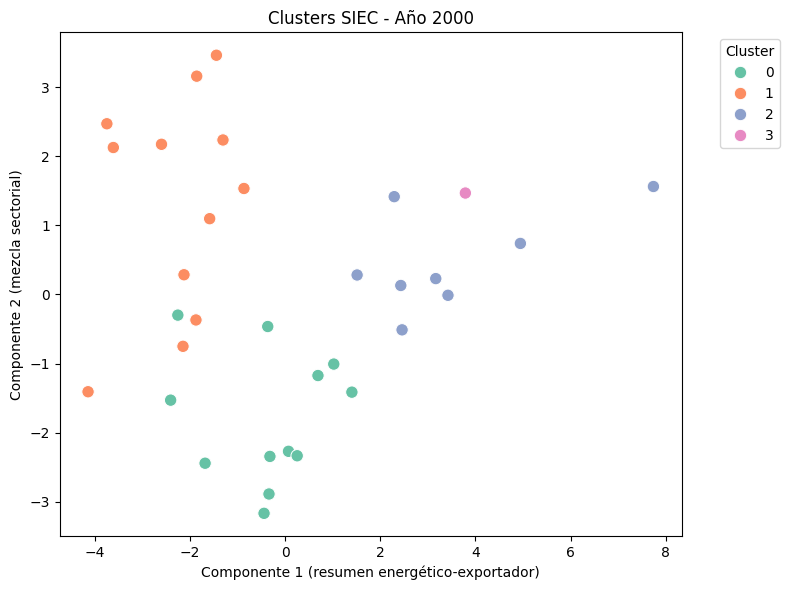


=== Clusters para el año 2010 ===
cluster
0    [AT, BE, CZ, DE, DK, ES, FI, FR, HU, IT, NL, N...
1                 [AL, CY, IS, LT, LU, LV, ME, MT, XK]
2                                                 [EE]
3             [BG, EL, HR, IE, MK, RO, RS, SI, TR, UA]
Name: geo, dtype: object


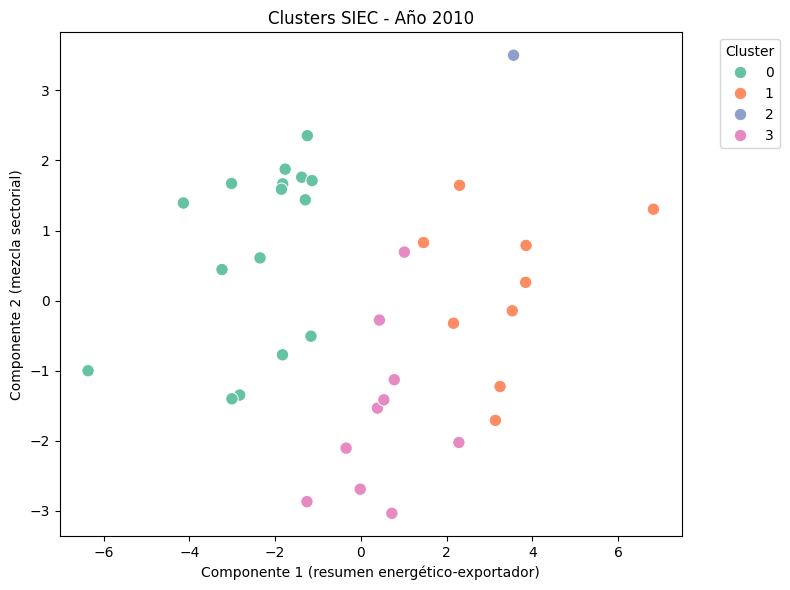


=== Clusters para el año 2020 ===
cluster
0             [AL, CY, IS, LT, LU, LV, ME, MK, MT, XK]
1                 [BA, BG, EL, HR, RO, RS, SI, TR, UA]
2    [AT, BE, CZ, DE, DK, ES, FI, FR, HU, IE, IT, N...
3                                                 [EE]
Name: geo, dtype: object


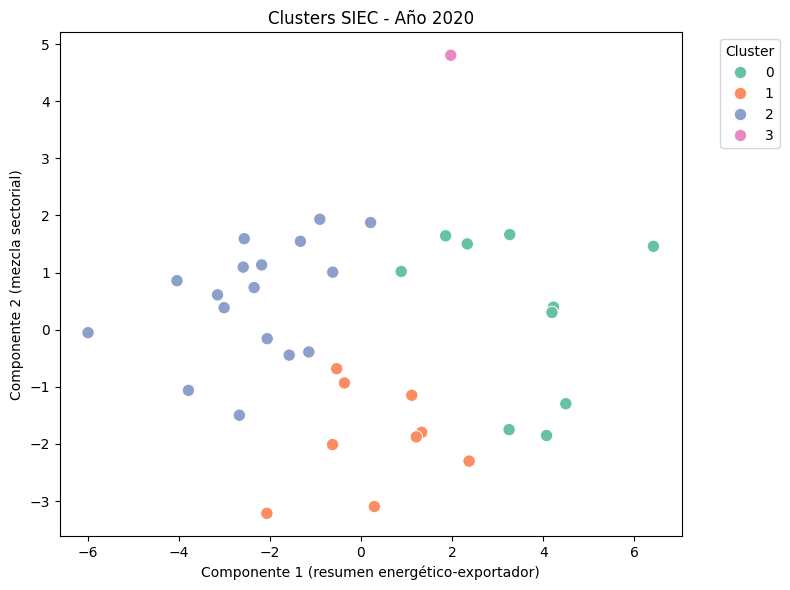


=== Países que cambiaron de grupo ===
   geo  cluster_2000  cluster_2010  cluster_2020  cambio
0   AL             2             1             0    True
1   AT             1             0             2    True
2   BE             1             0             2    True
3   BG             0             3             1    True
4   CY             2             1             0    True
5   CZ             0             0             2    True
6   DE             1             0             2    True
7   DK             1             0             2    True
8   EE             3             2             3    True
9   EL             0             3             1    True
10  ES             1             0             2    True
11  FI             1             0             2    True
12  FR             1             0             2    True
13  HR             0             3             1    True
14  HU             0             0             2    True
15  IE             2             3             2 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd

key_years = [2000, 2010, 2020]
K = 4

df_clusters = df_siec_filtered.reset_index(drop=False).copy()
df_periods = df_clusters[df_clusters["TIME_PERIOD"].isin(key_years)].copy()

vars_cluster = energy_cols + export_cols

cluster_results = {}

for year in key_years:
    data_year = df_periods[df_periods["TIME_PERIOD"] == year].copy()
    X = data_year[vars_cluster]
    X_scaled = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=K, random_state=42, n_init=50)
    data_year["cluster"] = kmeans.fit_predict(X_scaled)

    cluster_results[year] = data_year[["geo", "cluster"]]

    print(f"\n=== Clusters for year {year} ===")
    print(data_year.groupby("cluster")["geo"].agg(list))

    pca_vis = PCA(n_components=2)
    X_vis = pca_vis.fit_transform(X_scaled)

    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=X_vis[:,0], y=X_vis[:,1],
        hue=data_year["cluster"], palette="Set2", s=80
    )
    plt.title(f"SIEC Energy-Export Clusters - {year}")
    plt.xlabel("Component 1 (Overall energy-export profile)")
    plt.ylabel("Component 2 (Sectoral mix)")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

df_evolution = (
    cluster_results[key_years[0]]
    .merge(cluster_results[key_years[1]], on="geo", suffixes=("_2000", "_2010"))
    .merge(cluster_results[key_years[2]], on="geo")
    .rename(columns={"cluster": "cluster_2020"})
)

df_evolution["changed"] = (
    (df_evolution["cluster_2000"] != df_evolution["cluster_2010"]) |
    (df_evolution["cluster_2010"] != df_evolution["cluster_2020"])
)

print("\n=== Countries that changed cluster ===")
print(df_evolution[df_evolution["changed"]][["geo", "cluster_2000", "cluster_2010", "cluster_2020"]])

labels = [f"{y} - C{i}" for y in key_years for i in range(K)]
sources, targets, values = [], [], []

for i in range(len(key_years) - 1):
    temp = cluster_results[key_years[i]].merge(
        cluster_results[key_years[i+1]], on="geo", suffixes=("_src", "_dst")
    )
    counts = temp.groupby(["cluster_src", "cluster_dst"]).size().reset_index(name="count")
    for _, row in counts.iterrows():
        sources.append(row["cluster_src"] + K * i)
        targets.append(row["cluster_dst"] + K * (i + 1))
        values.append(row["count"])

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=labels,
        color=["#66c2a5","#fc8d62","#8da0cb","#e78ac3"] * len(key_years)
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(160,160,160,0.4)"
    )
)])
fig.update_layout(
    title_text="Evolution of Energy-Export Clusters (2000 to 2010 to 2020)",
    font=dict(size=12),
    height=500
)
fig.show()